# Network analysis with CellOracle

## 0. Prepare everything

In [ ]:
# conda activate celloracle_env

In [1]:
# 0. Import libraries

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
import celloracle as co
co.__version__

'0.10.14'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [4]:
# 0.2. Make a folder to save graph

save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

## 1. Load data

In [5]:
# 1.1 load the processed gene expression data (anndata)
#adata=sc.read("allNew_scanpy_subkeratins.h5ad")
adata=sc.read("woundcell_celloracle.h5ad")
adata

AnnData object with n_obs × n_vars = 10064 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'seurat_clusters', 'upCellTypes', 'monocle3_pseudotime', 'UMAP_1', 'UMAP_2', 'barcode'
    var: '_index', 'features'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [6]:
# OBS! The raw matrix has numericals instead of gene names as var.index, also make sure column name is correct!
adata.raw.var.rename(columns = {'_index':'features'}, inplace = True)
adata.raw.var.index = adata.var.index
adata = adata.raw.to_adata()

adata.var.index = adata.var['features']
print(adata)
print(adata.obs[["upCellTypes"]].value_counts())

AnnData object with n_obs × n_vars = 10064 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'seurat_clusters', 'upCellTypes', 'monocle3_pseudotime', 'UMAP_1', 'UMAP_2', 'barcode'
    var: 'features'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
upCellTypes
Spi_mig        3736
Spi_I          1732
Bas_I          1250
Spi_II_a       1035
Bas_prolif      850
Bas_mig         821
Spi_II_b        440
Gra_I           150
Spi_III          50
dtype: int64


In [7]:
# read the Top 3000 variable genes from seurat since oracle will keep the 1000~3000 genes by default
vg=pd.read_csv("allkera_variableGenes_seurat.csv")

adata=adata[:,vg['gene']]
adata

View of AnnData object with n_obs × n_vars = 10064 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'seurat_clusters', 'upCellTypes', 'monocle3_pseudotime', 'UMAP_1', 'UMAP_2', 'barcode'
    var: 'features'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

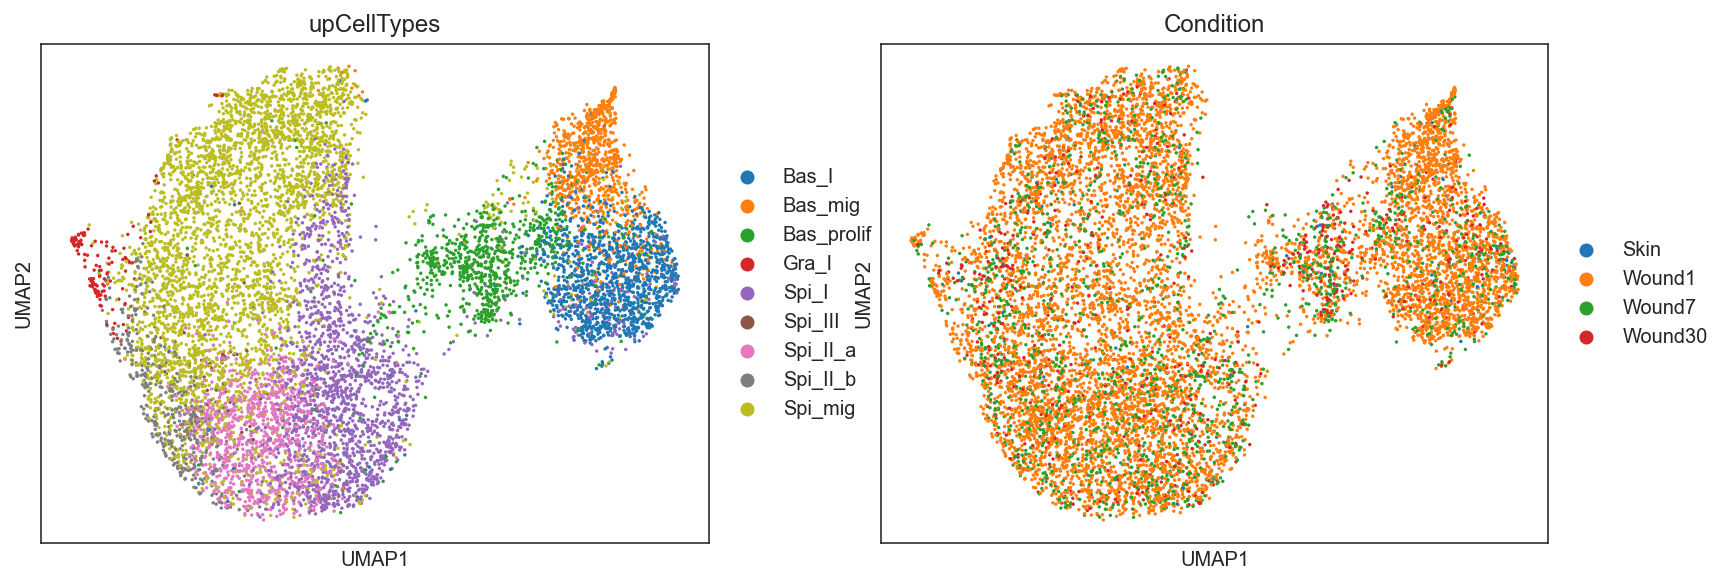

In [8]:
sc.pl.umap(adata, color=['upCellTypes', 'Condition'])

In [9]:
# 1.2 load base-GRN data
# base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN() # Load TF info which was made from mouse cell atlas dataset.
base_GRN = co.data.load_human_promoter_base_GRN(version="hg38_gimmemotifsv5_fpr2", force_download=False)

# Check data
base_GRN.head()

Loading prebuilt promoter base-GRN. Version: hg38_gimmemotifsv5_fpr2


,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100009853_100010953,DNMBP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_100081785_100082885,CPN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,chr10_100185877_100186977,ERLIN1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_100186978_100187057,ERLIN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_100229510_100230610,CHUK,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Make Oracle object

In [10]:
# Instantiate Oracle object
oracle = co.Oracle()

### 2.1 load gene expression data into oracle object

In [11]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'seurat_clusters', 'upCellTypes', 'monocle3_pseudotime', 'UMAP_1', 'UMAP_2', 'barcode']
Dimensional reduction:  ['X_harmony', 'X_pca', 'X_umap']


In [12]:
# In this notebook, we use the unscaled mRNA count for the input of Oracle object.

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="upCellTypes",
                                   embedding_name="X_umap")

### 2.2 load base-GRN data into oracle object

In [13]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

### 2.3. (Optional) Add TF-target gene pair manually

We can add additional TF-target gene pairs manually.

For example, if there is a study or database that includes specific TF-target pairs, you can include this information using a python dictionary.

## 3. KNN imputation

CellOracle uses the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.

For the KNN imputation, we first need to calculate and select PCs.

### 3.1 PCA 

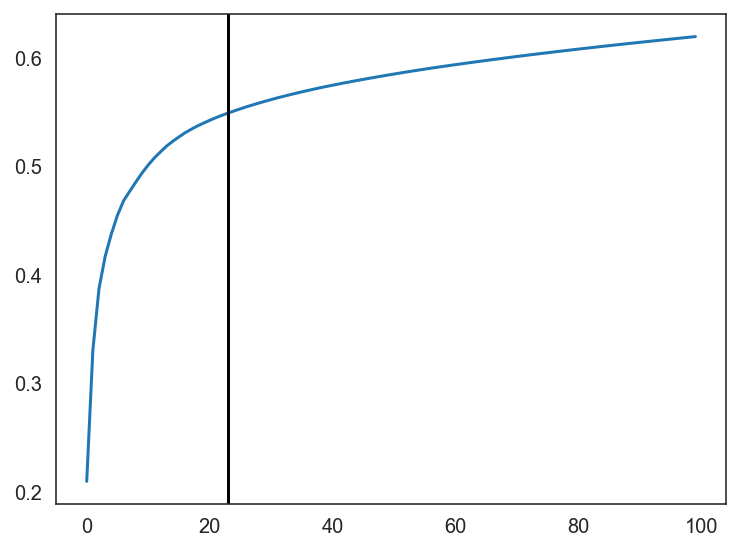

23


In [14]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

### 3.2 KNN imputation 

In [15]:
# Estimate the optimal number of nearest neighbors for KNN imputation.
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :10064


In [16]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :251


In [17]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

## 4. Save and Load 

In [18]:
# Save oracle object.
oracle.to_hdf5("woundcell.celloracle.oracle")

In [ ]:
# Load file.
#oracle = co.load_hdf5("woundcell.celloracle.oracle")

## 5. GRN calculation

The next step constructs a cluster-specific GRN for all clusters.

You can calculate GRNs with the get_links function, and it will return the results as a Links object. The Links object stores the inferred GRNs and the corresponding metadata. Most network structure analysis is performed with the Links object.

A GRN will be calculated for each cluster/sub-group. In the example below, we construct GRN for each unit of the "louvain_annot" clustering.

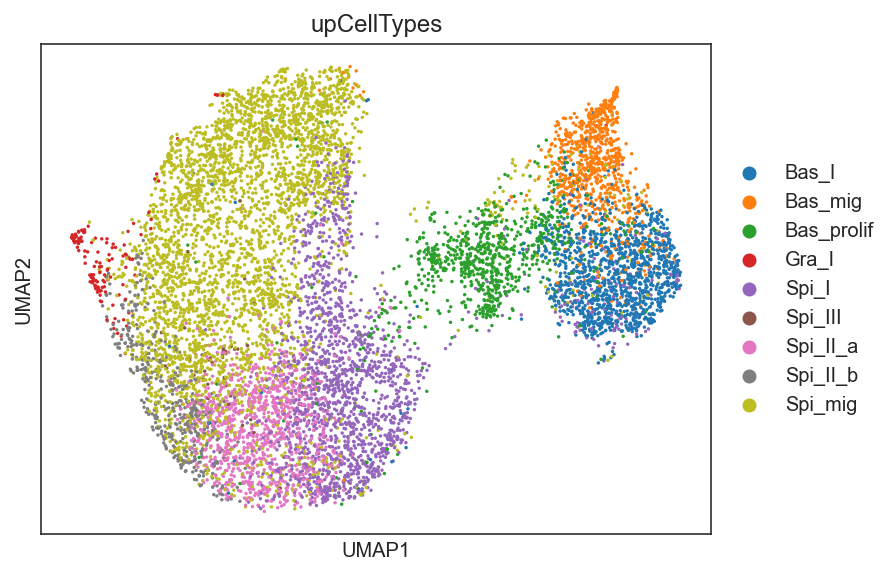

In [19]:
# Check clustering data
sc.pl.umap(oracle.adata, color="upCellTypes")

### 5.1 Get and save GRNs 

In [20]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="upCellTypes", alpha=10,
                         verbose_level=10)

  0%|          | 0/9 [00:00<?, ?it/s]

Inferring GRN for Bas_I...


  0%|          | 0/2792 [00:00<?, ?it/s]

Inferring GRN for Bas_mig...


  0%|          | 0/2792 [00:00<?, ?it/s]

Inferring GRN for Bas_prolif...


  0%|          | 0/2792 [00:00<?, ?it/s]

Inferring GRN for Gra_I...


  0%|          | 0/2792 [00:00<?, ?it/s]

Inferring GRN for Spi_I...


  0%|          | 0/2792 [00:00<?, ?it/s]

Inferring GRN for Spi_III...


  0%|          | 0/2792 [00:00<?, ?it/s]

Inferring GRN for Spi_II_a...


  0%|          | 0/2792 [00:00<?, ?it/s]

Inferring GRN for Spi_II_b...


  0%|          | 0/2792 [00:00<?, ?it/s]

Inferring GRN for Spi_mig...


  0%|          | 0/2792 [00:00<?, ?it/s]

CPU times: user 11min 23s, sys: 46.2 s, total: 12min 9s
Wall time: 15min 28s


In [21]:
# Save Links object.
links.to_hdf5(file_path="woundcells.celloracle.links")

In [22]:
links.links_dict.keys()

dict_keys(['Bas_I', 'Bas_mig', 'Bas_prolif', 'Gra_I', 'Spi_I', 'Spi_III', 'Spi_II_a', 'Spi_II_b', 'Spi_mig'])

In [23]:
links.links_dict["Bas_mig"]

,source,target,coef_mean,coef_abs,p,-logp
0,NR4A2,A1BG,0.004422,0.004422,1.653626e-12,11.781563
1,KLF5,A1BG,0.004420,0.004420,5.481122e-08,7.261131
2,RORA,A1BG,-0.002186,0.002186,6.685854e-08,7.174843
3,MEF2A,A1BG,-0.002331,0.002331,7.543623e-05,4.122420
4,KLF6,A1BG,0.004838,0.004838,1.164710e-08,7.933782
...,...,...,...,...,...,...
99710,IRF1,ZYX,-0.006467,0.006467,1.527144e-01,0.816120
99711,JUND,ZYX,0.084612,0.084612,1.831156e-11,10.737275
99712,KLF4,ZYX,0.161846,0.161846,6.464446e-18,17.189469
99713,BHLHE40,ZYX,-0.027232,0.027232,9.770436e-05,4.010086


## 6. Network preprocessing

### 6.1. Filter network edges

Using the base GRN, CellOracle constructs the GRN models as a lits of directed edges between a TF and its target genes. We need to remove the weak edges or insignificant edges before doing network structure analysis.

We filter the network edges as follows.

Remove uncertain network edges based on the p-value.

Remove weak network edge. In this tutorial, we keep the top 2000 edges ranked by edge strength.

The raw network data is stored in the links_dict attribute, while the filtered network data is stored in the filtered_links attribute.

In [24]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

### 6.2. Degree distribution

In [25]:
# Network degree, which is the number of edges for each node, is one of the important metrics used to investigate the network structure
plt.rcParams["figure.figsize"] = [9, 4.5]

Bas_I


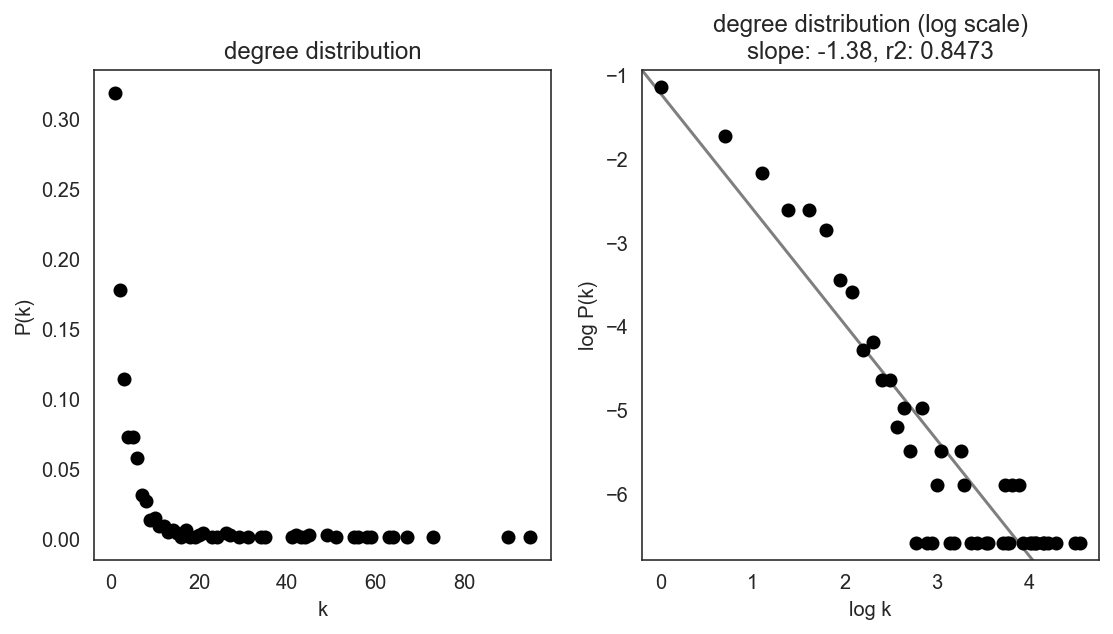

Bas_mig


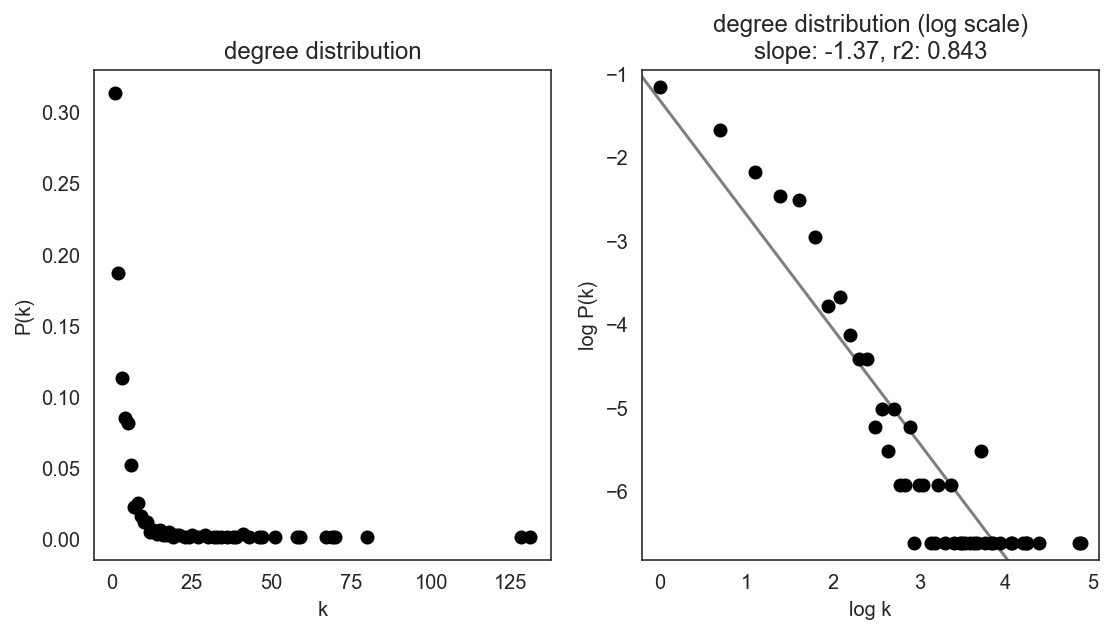

Bas_prolif


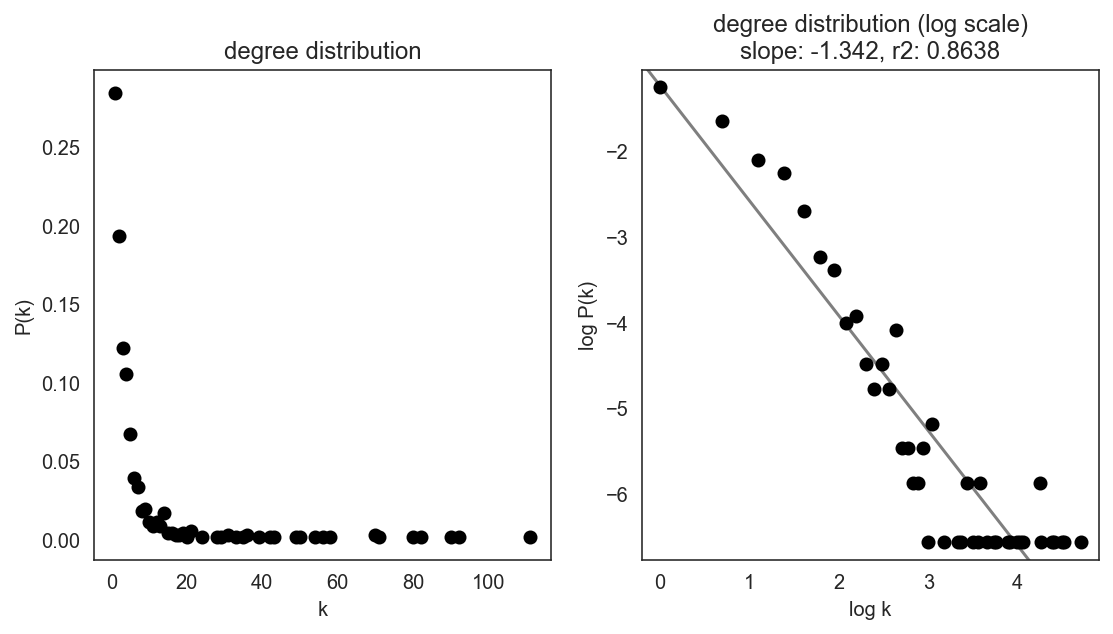

Gra_I


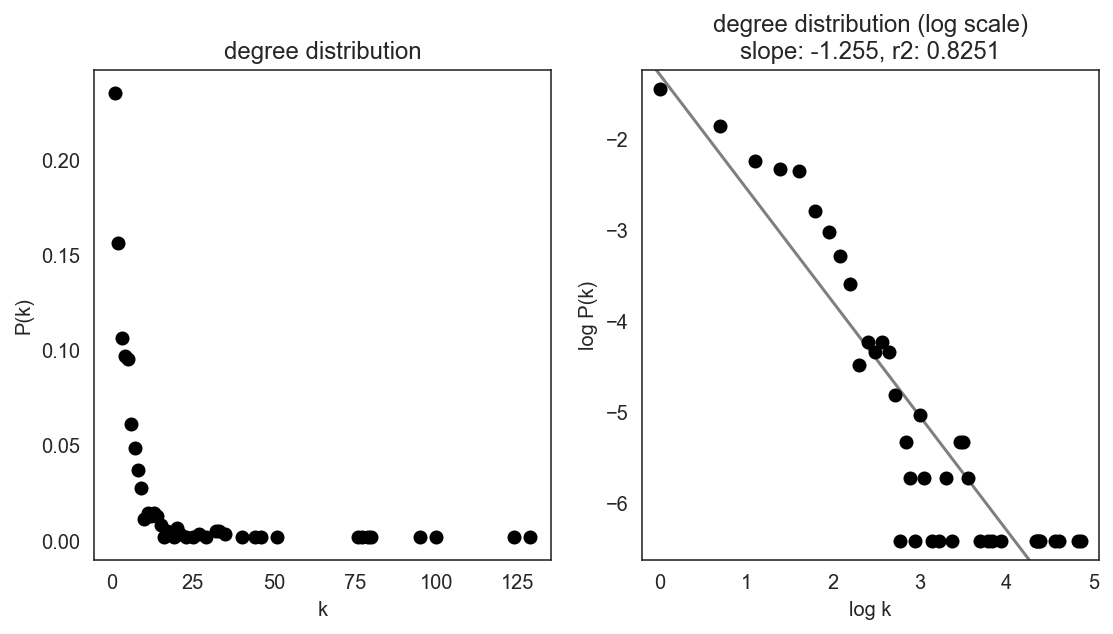

Spi_I


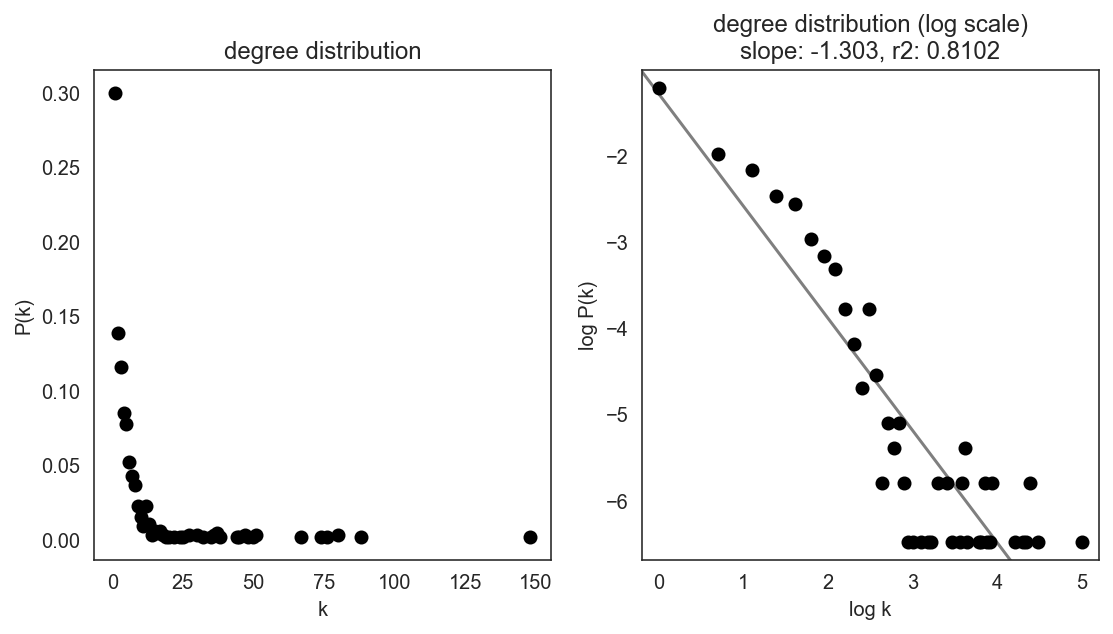

Spi_III


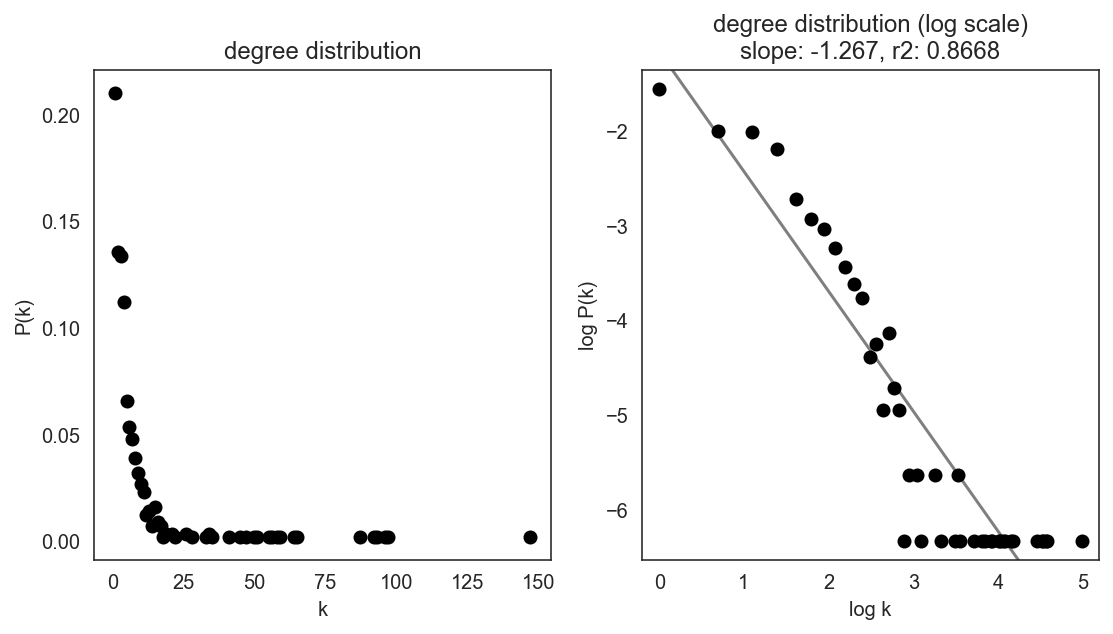

Spi_II_a


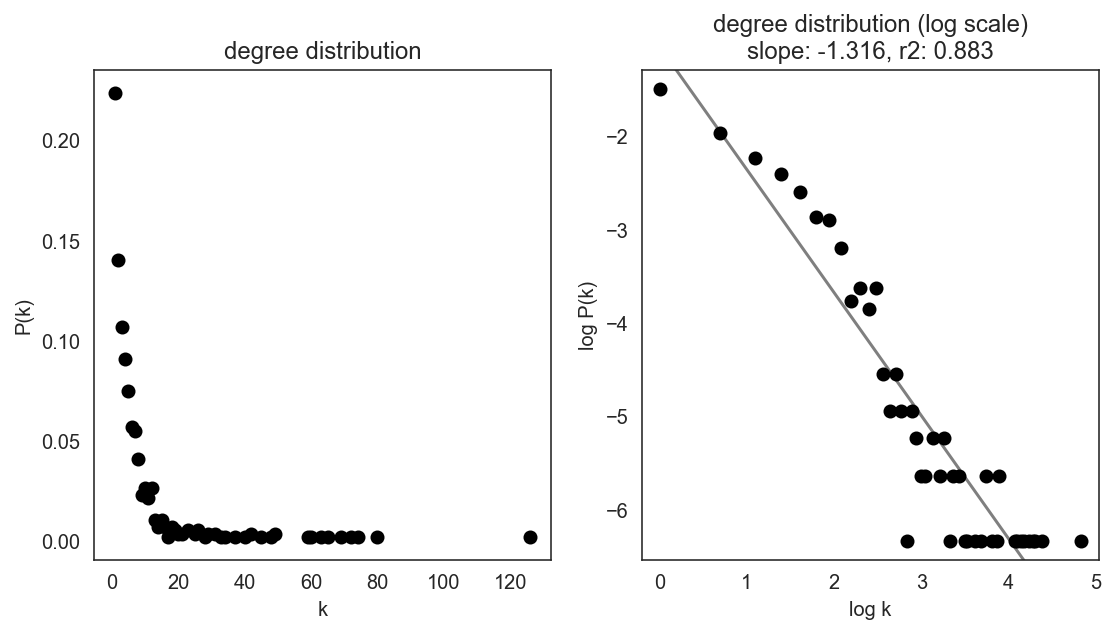

Spi_II_b


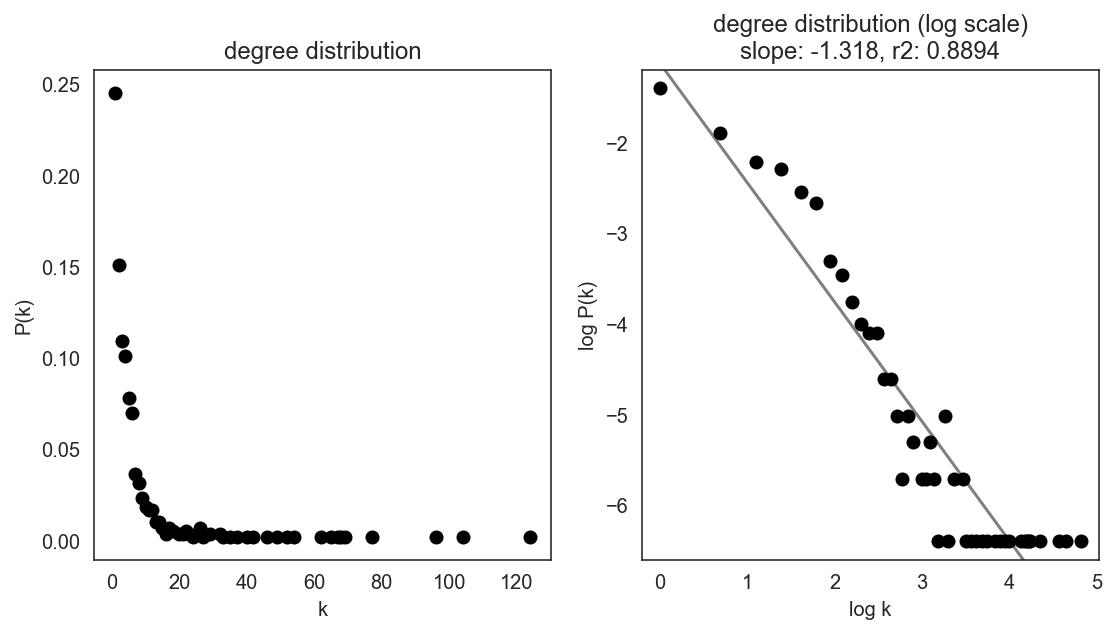

Spi_mig


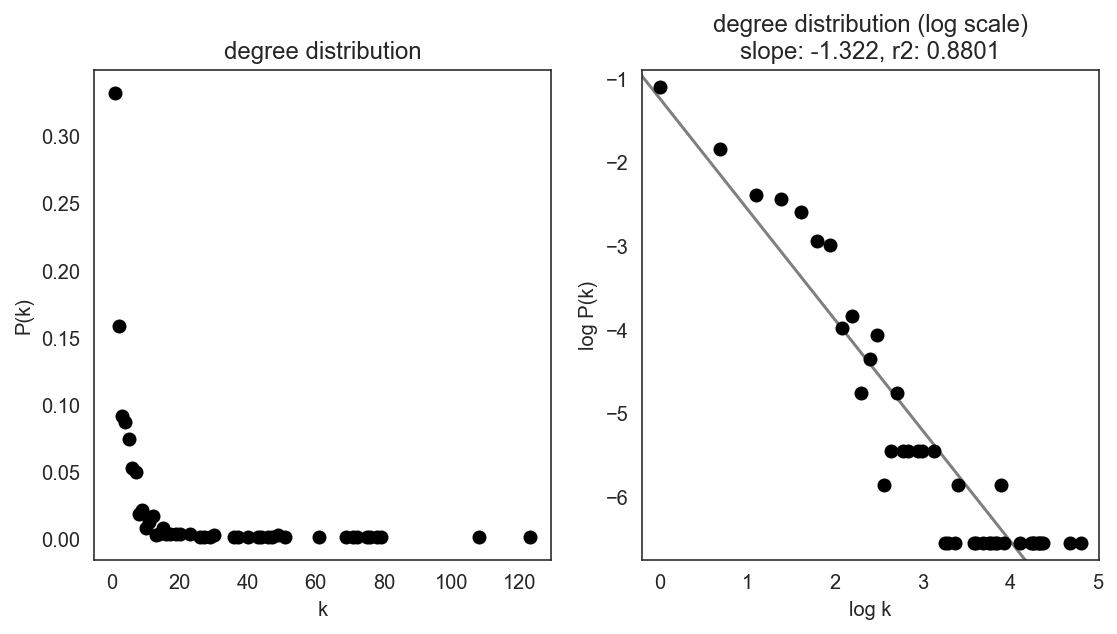

In [26]:
links.plot_degree_distributions(plot_model=True, 
                                               #save=f"{save_folder}/degree_distribution/",
                                               )

In [27]:
plt.rcParams["figure.figsize"] = [6, 6]

### 6.3. Calculate network score 

In [28]:
# Calculate network scores. 
links.get_network_score()

In [29]:
# Look at the score values
links.merged_score.head()

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
ABRACL,1,0.001381,1,0.001381,0,0.0,0.0,0.017645,Bas_I
ACTB,11,0.015193,11,0.015193,0,0.0,0.0,0.270815,Bas_I
ACTG1,4,0.005525,4,0.005525,0,0.0,0.0,0.094161,Bas_I
ACTN1,6,0.008287,6,0.008287,0,0.0,0.0,0.116972,Bas_I
ADIRF,6,0.008287,6,0.008287,0,0.0,0.0,0.188689,Bas_I


### 6.4. Save 

In [30]:
# Save processed GRNs. We will use this file during the in in silico TF perturbation analysis.
# Save Links object.
links.to_hdf5(file_path="woundcells.celloracle.links")

In [59]:
# You can load files with the following command.
#links = co.load_hdf5(file_path="woundcells.celloracle.links")

## 7. Network analysis; Network score for each gene 

## 7.1. Network score in each cluster 

In [31]:
# Check cluster name
links.cluster

['Bas_I',
 'Bas_mig',
 'Bas_prolif',
 'Gra_I',
 'Spi_I',
 'Spi_III',
 'Spi_II_a',
 'Spi_II_b',
 'Spi_mig']

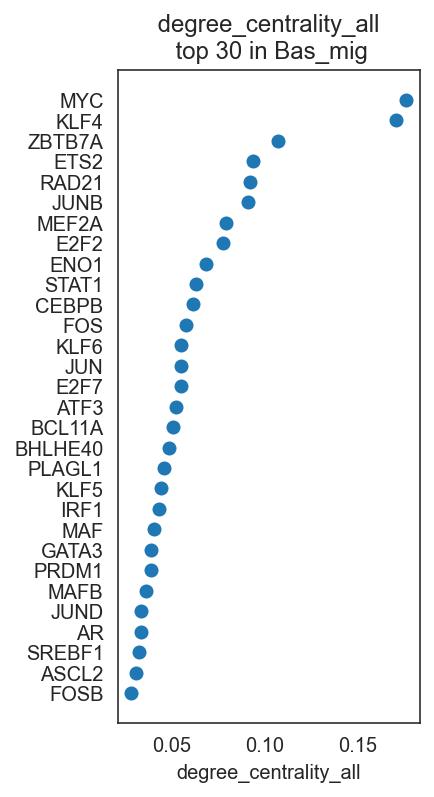

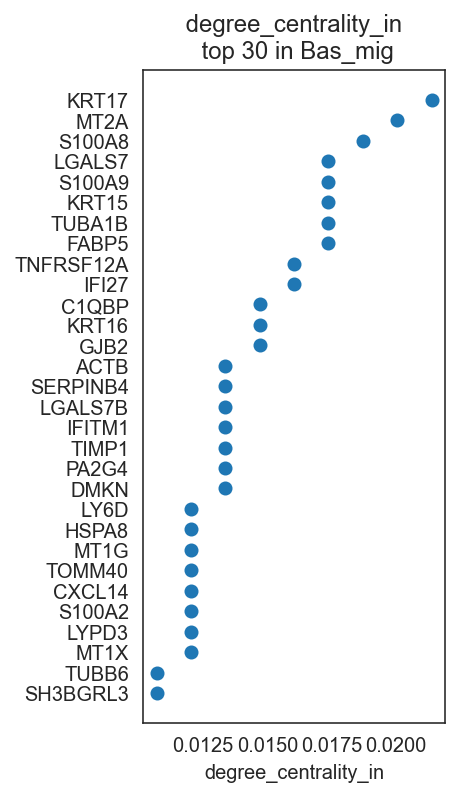

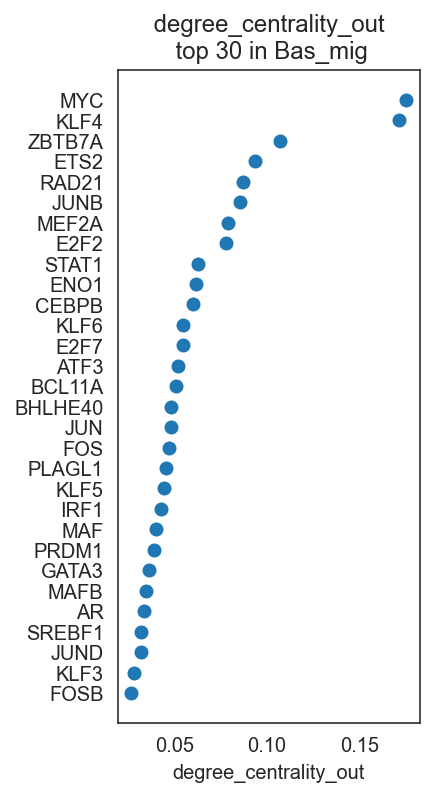

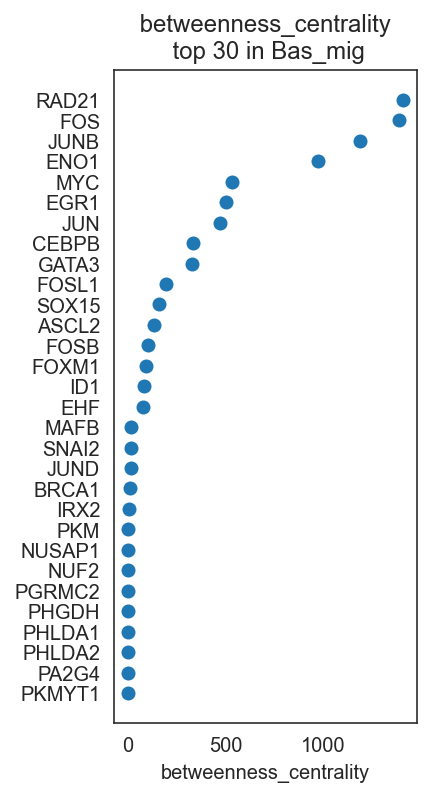

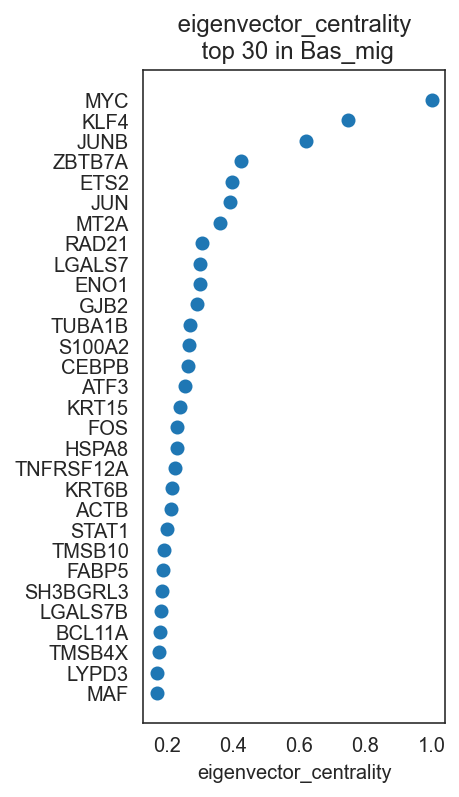

In [32]:
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="Bas_mig", n_gene=30, save=f"{save_folder}/ranked_score")

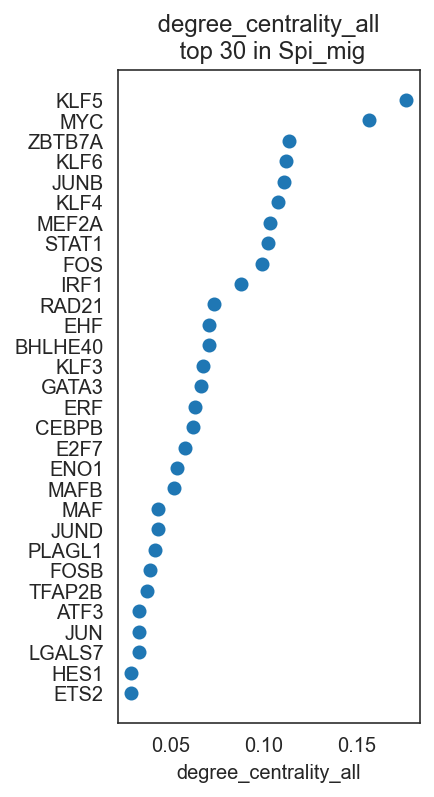

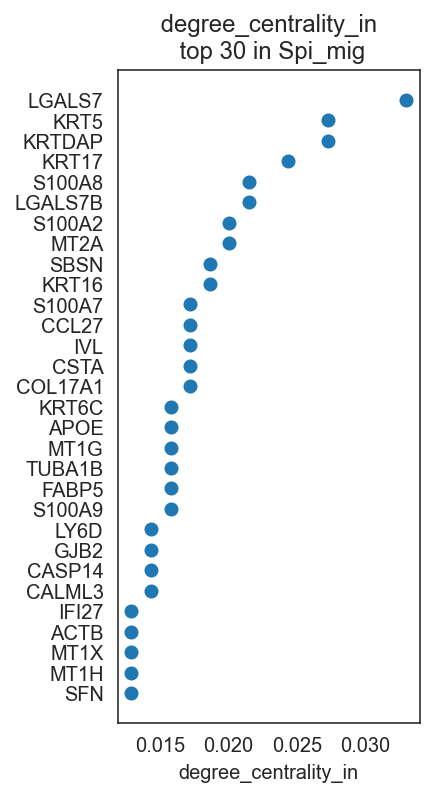

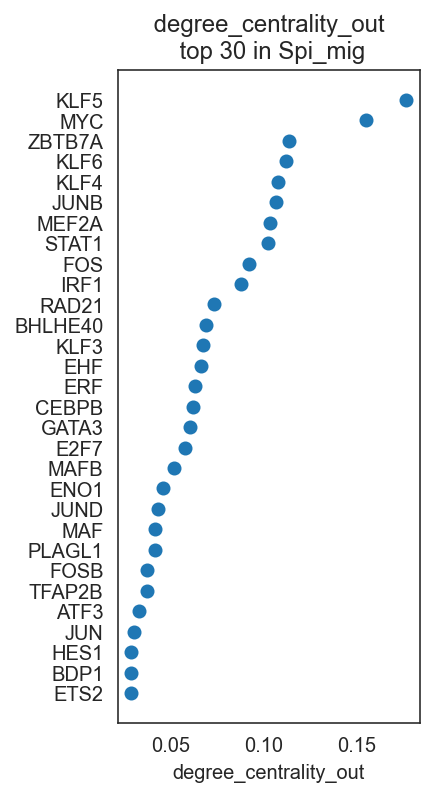

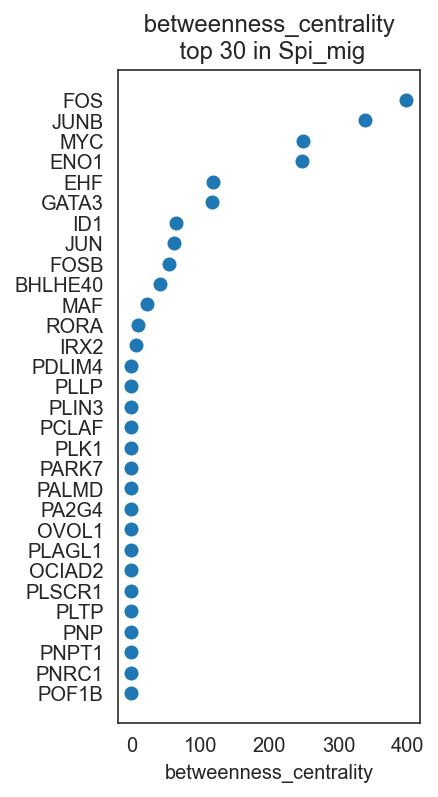

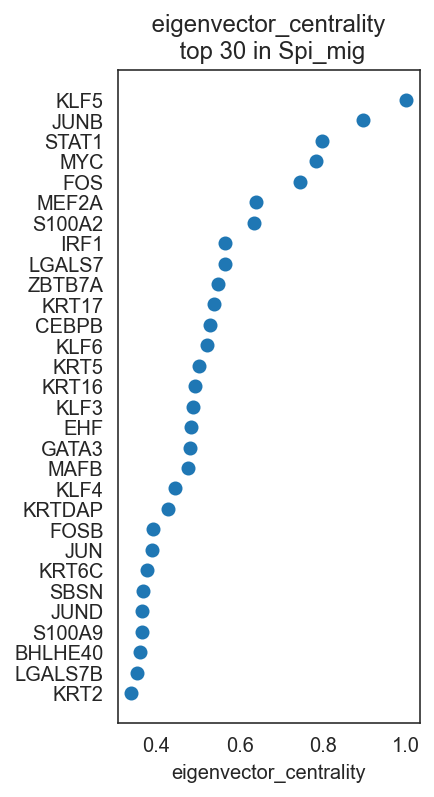

In [33]:
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="Spi_mig", n_gene=30, save=f"{save_folder}/ranked_score")

## 7.2. Network score comparison between two clusters

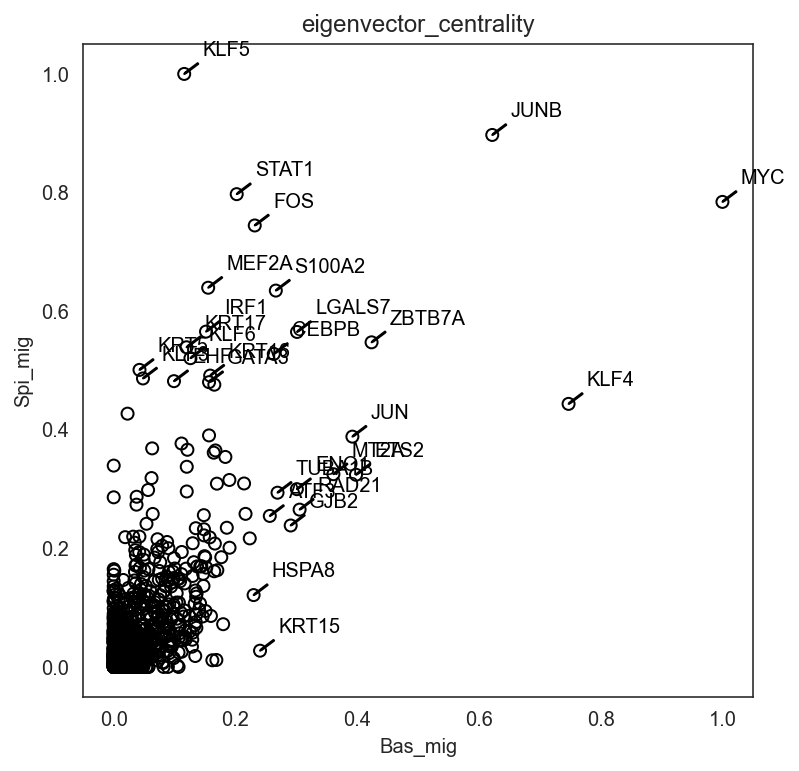

In [34]:
# By comparing network scores between two clusters, we can analyze differences in GRN structure.
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="Bas_mig", cluster2="Spi_mig", 
                               percentile=98,
                               save=f"{save_folder}/score_comparison")

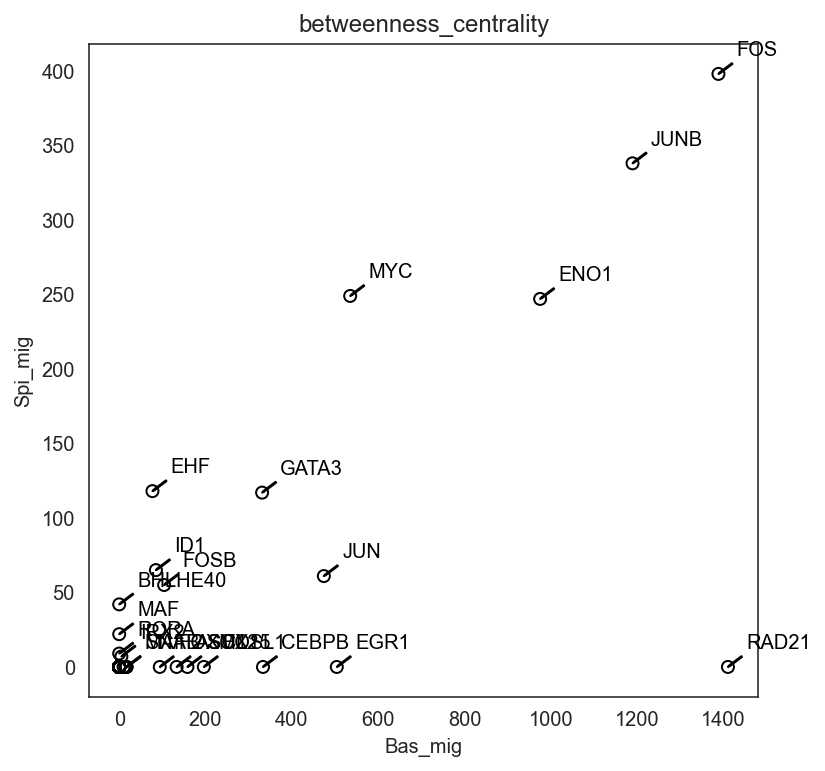

In [35]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="Bas_mig", cluster2="Spi_mig", 
                               percentile=98, 
                               save=f"{save_folder}/score_comparison")

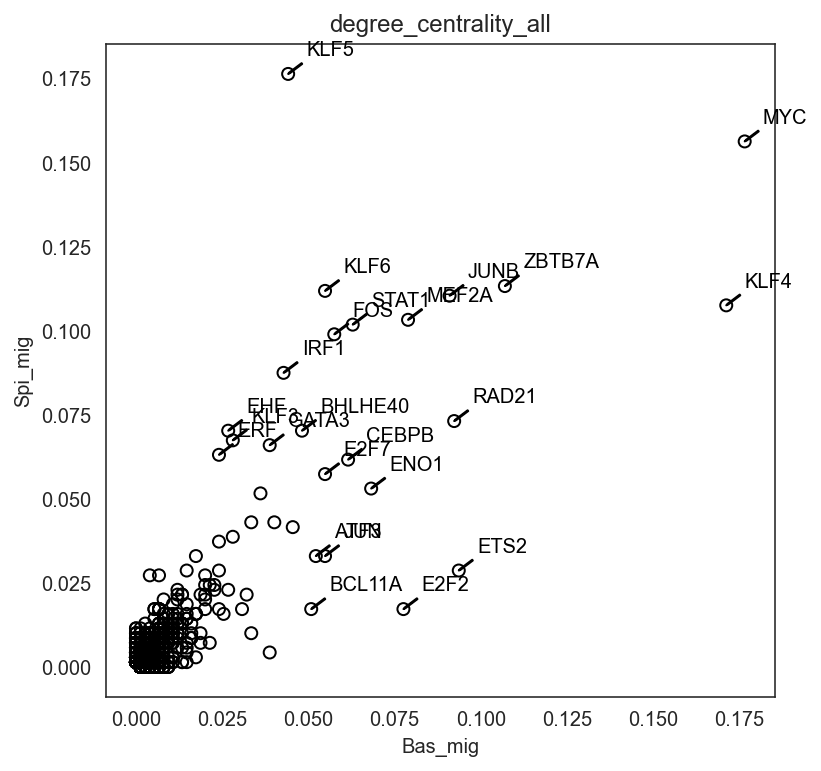

In [36]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="degree_centrality_all",
                               cluster1="Bas_mig", cluster2="Spi_mig", 
                               percentile=98, save=f"{save_folder}/score_comparison")

## 7.3. Network score dynamics

FOSL1


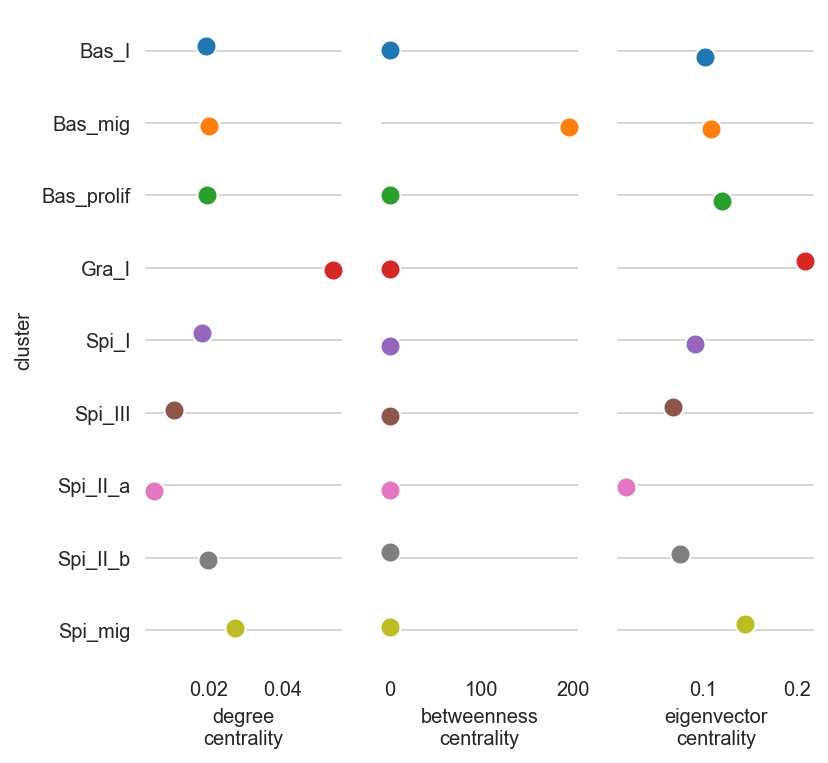

In [37]:
# Visualize interested gene network score dynamics
links.plot_score_per_cluster(goi="FOSL1", save=f"{save_folder}/network_score_per_gene/")

FOSL1


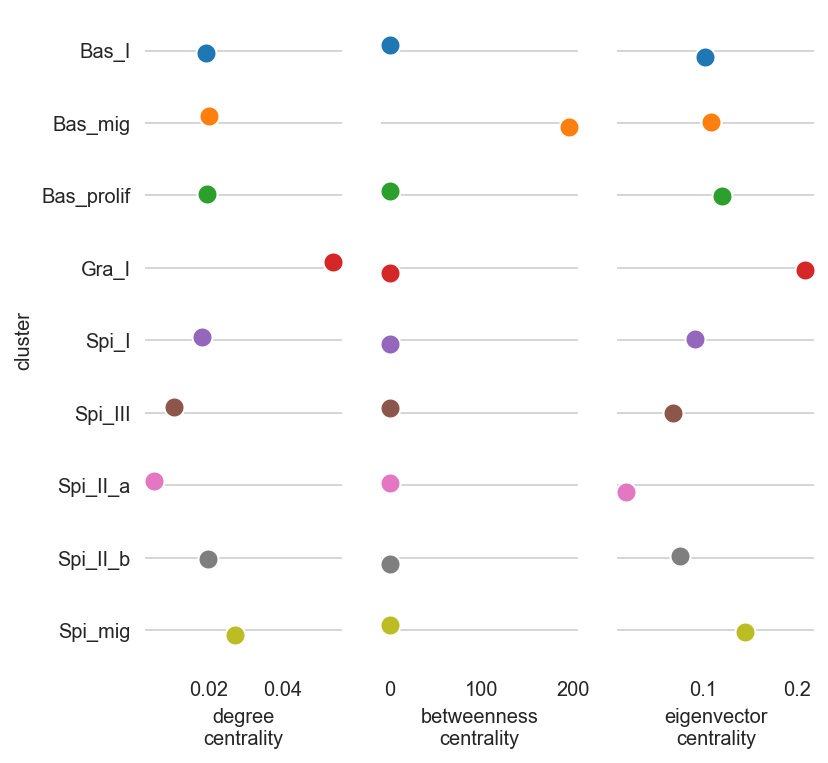

In [38]:
# Visualize Cebpa network score dynamics
links.plot_score_per_cluster(goi="FOSL1")